In [117]:
from itertools import combinations

import pandas as pd
import numpy as np
import os
import datetime
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from analysis.database import get_config

sns.set_style("ticks")


In [118]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_06"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [119]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]

df_cpvt_unique_by_patient = df_cpvt.drop_duplicates(subset="individual_id")

# MUST REMOVE DUPLICATES BECAUSE IT VIOLATES THE 
# INDEPENDENCE ASSUMPTION OF STATISTICAL TESTS
df_cpvt_analysis = df_cpvt.drop_duplicates(subset="individual_id", keep=False)

AGE_OF_ONSET_COL = "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1"

In [121]:
print(f"Number of CPVT patients: {len(df_cpvt_unique_by_patient)}")
print(
    f"Number of patients that can be used for analysis: {len(df_cpvt_analysis)}")

Number of CPVT patients: 964
Number of patients that can be used for analysis: 963


In [122]:
from typing import Literal

BASE_LABEL_FONT_SIZE = 10
BASE_TITLE_FONT_SIZE = 10
BASE_TICK_FONT_SIZE = 8


def set_figure_size(
        x_label: str,
        y_label: str,
        title_: str,
        x_tick_rotation: int = 0,
        x_tick_ha: Literal["center", "right", "left"] = "center",
        x_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        y_label_fontsize: int = BASE_LABEL_FONT_SIZE,
        title_fontsize: int = BASE_TITLE_FONT_SIZE,
        x_tick_fontsize: int = BASE_TICK_FONT_SIZE,
        y_tick_fontsize: int = BASE_TICK_FONT_SIZE,
):
    plt.xlabel(x_label, fontsize=x_label_fontsize)
    plt.ylabel(y_label, fontsize=y_label_fontsize)
    plt.title(title_, fontsize=title_fontsize)
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha, fontsize=x_tick_fontsize)
    plt.yticks(fontsize=y_tick_fontsize)
    plt.tight_layout()


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir, name + '.' + fmt), dpi=300)

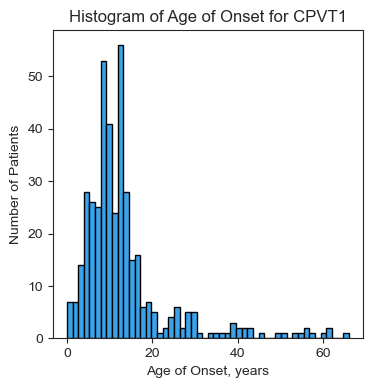

In [123]:
plt.figure(figsize=(4, 4))

# histogram of age of onset
df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].hist(
    bins=50,
    color=sns.color_palette("husl", 9)[6],
    edgecolor="black"

)

plt.title("Histogram of Age of Onset for CPVT1")
plt.xlabel("Age of Onset, years")
plt.ylabel("Number of Patients")

# plt.axvline(median_aoo, color='tab:orange', linestyle='dashed', linewidth=1)
# plt.axvline(mean_aoo, color='tab:red', linestyle='dashed', linewidth=1)
#
# # Add text labels for median and mean
# plt.text(median_aoo, plt.ylim()[1] * 0.95, f'Median: {median_aoo:.2f}',
#          ha='right')
# plt.text(mean_aoo, plt.ylim()[1] * 0.95, f'Mean: {mean_aoo:.2f}',
#          ha='left')

plt.grid(False)

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"hist_age_of_onset.{fmt}"), format=fmt,
        dpi=300
    )

In [124]:
def get_median_and_mean(df_calc: pd.DataFrame):
    mean = df_calc[AGE_OF_ONSET_COL].mean()
    median = df_calc[AGE_OF_ONSET_COL].median()
    q1 = df_calc[AGE_OF_ONSET_COL].quantile(0.25)
    q3 = df_calc[AGE_OF_ONSET_COL].quantile(0.75)

    return mean, median, q1, q3


# print stats: mean, median, iqr
def print_median_and_iqr(df_calc: pd.DataFrame, name: str):
    mean, median, q1, q3 = get_median_and_mean(df_calc)

    print(
        f"{name}: mean={mean:.2f}, median={median:.2f}, IQR={q1:.2f}-{q3:.2f}, n={len(df_calc)}"
    )


print_median_and_iqr(
    df_cpvt_unique_by_patient[
        df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].notnull()],
    "CPVT1 (all)"
)

CPVT1 (all): mean=13.32, median=11.00, IQR=7.00-14.00, n=409


In [125]:
# calculate skewness and kurtosis
skewness = df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].skew()
kurtosis = df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].kurtosis()

print(f"Skewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f}")

Skewness: 2.43, Kurtosis: 6.85


## Age of onset vs Exon

In [126]:
filtered_exon = \
    df_cpvt_analysis.dropna(subset=[AGE_OF_ONSET_COL, "exon_start"])[
        ["individual_id", "exon_start", AGE_OF_ONSET_COL]].copy()
filtered_exon["exon_start"] = filtered_exon["exon_start"].astype(int)

num_pat_per_exon = filtered_exon["exon_start"].value_counts().reset_index()
num_pat_per_exon.head()

,exon_start,count
0,90,54
1,14,47
2,8,34
3,47,21
4,105,18


In [127]:
MIN_NUM_INDIVIDUALS = 5

# fig, ax = plt.subplots(figsize=(15, 5))
filtered_exon = filtered_exon[
    filtered_exon["exon_start"].isin(
        num_pat_per_exon[num_pat_per_exon["count"] >= MIN_NUM_INDIVIDUALS][
            "exon_start"]
    )
]

filtered_exon.head()

,individual_id,exon_start,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1
3,4,99,2.0
4,5,99,10.0
5,6,99,2.0
6,7,99,10.0
18,19,47,12.0


In [128]:
import scipy.stats as stats

age_of_onset_by_exon = filtered_exon.groupby("exon_start")

# Perform the Kruskal-Wallis test
stat_exon, p_exon = stats.kruskal(
    *[group[AGE_OF_ONSET_COL] for _, group in age_of_onset_by_exon]
)

print(
    f"Kruskal-Wallis H-test: H={stat_exon:.2f}, P={p_exon:.2g}, dof={len(age_of_onset_by_exon) - 1}, n={len(filtered_exon)}")

Kruskal-Wallis H-test: H=71.97, P=1.7e-07, dof=21, n=322


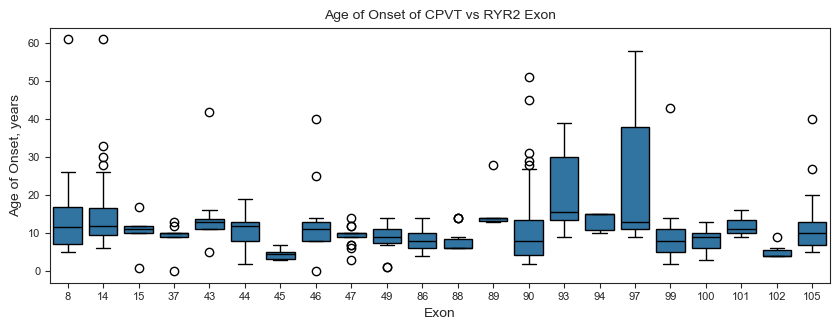

In [129]:
FIG_2_SIZE = (8.5, 3.4)

plt.figure(figsize=FIG_2_SIZE)

ax = sns.boxplot(
    data=filtered_exon,
    y=AGE_OF_ONSET_COL,
    x="exon_start",
    linewidth=1,
    width=0.8,
    # palette="Set1",
    # hue="exon",
    linecolor="black",
    # color=sns.color_palette("husl", 9)[6],
    # showfliers=False,
)

set_figure_size(
    "Exon",
    "Age of Onset, years",
    "Age of Onset of CPVT vs RYR2 Exon",
)

save_current_plot("age_of_onset_vs_exon")

plt.show()

## Age of onset vs Domain

In [130]:
# use colors from chimerax

CUSTOM_COLOR_PALLETTE = {
    "ntd": "7C93CB",
    "spry": "F8AE50",
    "jsol": "9F72B2",
    "bsol": "F1EA2E",
    "sclp": "61BC52",
    "csol": "0075BD",
    "taf": "CF5857",
    "tm": "A5A4A5",
    "ctd": "006C39"
}

In [131]:
filtered_domain = df_cpvt_analysis.dropna(subset=[AGE_OF_ONSET_COL, "domain"])[
    ["individual_id", AGE_OF_ONSET_COL, "domain"]
]

num_pat_per_domain = filtered_domain["domain"].value_counts().reset_index()
num_pat_per_domain

,domain,count
0,NTD,105
1,BSol,92
2,CSol,74
3,TM,63
4,CTD,26
5,TaF,23
6,SPRY,10
7,JSol,9
8,SCLP,2


In [132]:
# stats table (median, q1, q3)
qt_domains = filtered_domain.groupby("domain")[AGE_OF_ONSET_COL].quantile(
    [0.5, 0.25, 0.75]).unstack()

qt_domains

,0.50,0.25,0.75
domain,,,
BSol,10.0,8.00,14.00
CSol,8.0,6.00,14.00
CTD,12.0,7.00,14.00
JSol,10.0,9.00,10.00
NTD,12.0,9.00,16.00
SCLP,36.0,26.50,45.50
SPRY,12.0,8.75,12.75
TM,10.0,9.00,14.50
TaF,11.0,6.00,14.50


In [133]:
# mean
mean_median_domains = filtered_domain.groupby("domain")[AGE_OF_ONSET_COL].agg(
    ["mean"]
)

mean_median_domains

,mean
domain,
BSol,15.173913
CSol,10.777027
CTD,12.692308
JSol,9.236667
NTD,13.884952
SCLP,36.000000
SPRY,13.200000
TM,13.095238
TaF,13.130435


In [134]:
# domains
domains_df = pd.read_csv("./data_commit/ryr2_subdomains.csv")

In [135]:
# combine tables
domain_stats = pd.concat(
    [mean_median_domains, qt_domains, num_pat_per_domain.set_index("domain")],
    axis=1
)
domain_stats.columns = ["mean", "median", "q1", "q3", "count"]
domain_stats["mean"] = domain_stats["mean"].round(2)

domain_stat_order = [
    v for v in domains_df["domains"].dropna().str.strip().values
    if v in set(domain_stats.index)
]

print(domain_stat_order)

domain_stats = domain_stats.loc[domain_stat_order]

domain_stats.to_csv(figures_dir / "domain_stats.csv")

domain_stats

['NTD', 'SPRY', 'JSol', 'BSol', 'SCLP', 'CSol', 'TaF', 'TM', 'CTD']


,mean,median,q1,q3,count
domain,,,,,
NTD,13.88,12.0,9.00,16.00,105
SPRY,13.20,12.0,8.75,12.75,10
JSol,9.24,10.0,9.00,10.00,9
BSol,15.17,10.0,8.00,14.00,92
SCLP,36.00,36.0,26.50,45.50,2
CSol,10.78,8.0,6.00,14.00,74
TaF,13.13,11.0,6.00,14.50,23
TM,13.10,10.0,9.00,14.50,63
CTD,12.69,12.0,7.00,14.00,26


In [136]:

# fig, ax = plt.subplots(figsize=(15, 5))
filtered_domain_gt_5 = filtered_domain[
    filtered_domain["domain"].isin(
        num_pat_per_domain[num_pat_per_domain["count"] >= MIN_NUM_INDIVIDUALS][
            "domain"]
    )
]

domain_order_gt5 = [
    v
    for v in domains_df["domains"].dropna().str.strip().values
    if v in set(filtered_domain_gt_5["domain"])
]

domain_order_gt5

['NTD', 'SPRY', 'JSol', 'BSol', 'CSol', 'TaF', 'TM', 'CTD']

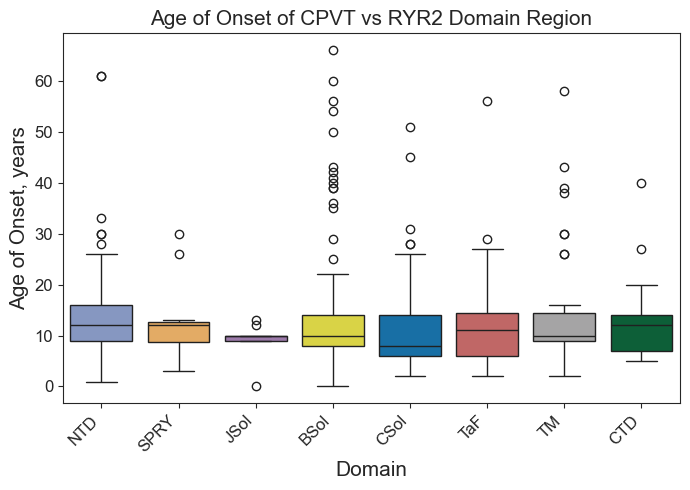

In [153]:
domain_color_mapping = {
    domain: "#" + CUSTOM_COLOR_PALLETTE[domain.lower()]
    for domain in domain_order_gt5
}

FIGURE_3_SIZE = (7, 5)

sns.set_style("ticks")
plt.figure(figsize=FIGURE_3_SIZE)

ax = sns.boxplot(
    data=filtered_domain_gt_5,
    y=AGE_OF_ONSET_COL,
    x="domain",
    linewidth=1,
    width=0.8,
    palette=domain_color_mapping,
    hue="domain",
    legend=False,
    order=domain_order_gt5,
    # showfliers=False,
)

plt.setp(ax.collections, alpha=.6)

set_figure_size(
    "Domain",
    "Age of Onset, years",
    "Age of Onset of CPVT vs RYR2 Domain Region",
    x_tick_rotation=45,
    x_tick_ha="right",
    # set sizes 1.5x bigger for ticks and axes
    x_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
    x_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
    title_fontsize=BASE_TITLE_FONT_SIZE * 1.5
)

save_current_plot("age_of_onset_vs_domain")

plt.show()

In [154]:
# Perform the Kruskal-Wallis test on domains with at least 5 patients
stat_domain, p_domain = stats.kruskal(
    *[group[AGE_OF_ONSET_COL] for _, group in
      filtered_domain_gt_5.groupby("domain")]
)

print(
    f"Kruskal-Wallis H-test: H={stat_domain:.2f}, P={p_domain:.2g}, n={len(filtered_domain_gt_5)}")

Kruskal-Wallis H-test: H=16.03, P=0.025, n=402


In [155]:
import scikit_posthocs as sp

In [156]:
# age of onset vs EXON
pvals_domains = sp.posthoc_dunn(
    filtered_domain_gt_5,
    val_col=AGE_OF_ONSET_COL,
    group_col="domain",
    p_adjust="bonferroni",
)
pvals_domains

,BSol,CSol,CTD,JSol,NTD,SPRY,TM,TaF
BSol,1.000000,0.709312,1.0,1.0,1.000000,1.0,1.0,1.0
CSol,0.709312,1.000000,1.0,1.0,0.004033,1.0,1.0,1.0
CTD,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
JSol,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
NTD,1.000000,0.004033,1.0,1.0,1.000000,1.0,1.0,1.0
SPRY,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
TM,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0
TaF,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0


In [157]:
from itertools import combinations

for c1, c2 in combinations(pvals_domains.columns, 2):
    if pvals_domains.loc[c1, c2] < 0.05:
        print(f"{c1} vs {c2}: {pvals_domains.loc[c1, c2]:.6f}")

CSol vs NTD: 0.004033


We can see here that CSol and NTD are signifigantly different since the p value is 0.004033

## Subdomains

In [158]:
filtered_sub_domain = \
    df_cpvt_analysis.dropna(subset=[AGE_OF_ONSET_COL, "subdomain"])[
        ["individual_id", AGE_OF_ONSET_COL, "domain", "subdomain"]
    ]

num_pat_per_sub_domain = filtered_sub_domain[
    "subdomain"].value_counts().reset_index()
num_pat_per_sub_domain

,subdomain,count
0,BSol1,90
1,CSol(exEF-hand),69
2,NSol,50
3,NTD-A,46
4,pVSD,33
5,Pore,27
6,CTD,23
7,TaF,23
8,JSol,9
9,NTD-B,9


In [159]:
# stats
qt_sub_domains = filtered_sub_domain.groupby("subdomain")[
    AGE_OF_ONSET_COL].quantile(
    [0.5, 0.25, 0.75]).unstack()
qt_mean_sub_domains = filtered_sub_domain.groupby("subdomain")[
    AGE_OF_ONSET_COL].agg(
    ["mean"]
)

sub_domain_stats = pd.concat(
    [qt_mean_sub_domains, qt_sub_domains,
     num_pat_per_sub_domain.set_index("subdomain")],
    axis=1
)
sub_domain_stats.columns = ["mean", "median", "q1", "q3", "count"]
sub_domain_stats["mean"] = sub_domain_stats["mean"].round(2)

sub_domain_stat_order = [
    v for v in domains_df["subdomains"].dropna().str.strip().values
    if v in set(sub_domain_stats.index)
]

print(sub_domain_stat_order)

sub_domain_stats = sub_domain_stats.loc[sub_domain_stat_order]

sub_domain_stats.to_csv(figures_dir / "sub_domain_stats.csv")

sub_domain_stats

['NTD-A', 'NTD-B', 'NSol', 'SPRY1', 'SPRY2', 'SPRY3', 'RY1&2', 'JSol', 'BSol1', 'BSol2', 'RY3&4', 'SCLP', 'CSol(exEF-hand)', 'EF1&2', 'TaF', 'TM', 'Sx', 'pVSD', 'Pore', 'CTD', 'ZnF']


,mean,median,q1,q3,count
subdomain,,,,,
NTD-A,13.48,12.0,9.0,16.00,46
NTD-B,15.33,12.0,11.0,14.00,9
NSol,14.00,12.0,9.0,15.75,50
SPRY1,12.00,12.0,12.0,12.00,1
SPRY2,3.00,3.0,3.0,3.00,1
SPRY3,12.43,12.0,9.5,12.50,7
RY1&2,30.00,30.0,30.0,30.00,1
JSol,9.24,10.0,9.0,10.00,9
BSol1,14.63,10.0,8.0,13.00,90


In [160]:
sub_domain_gt_5 = filtered_sub_domain[
    filtered_sub_domain["subdomain"].isin(
        num_pat_per_sub_domain[
            num_pat_per_sub_domain["count"] >= MIN_NUM_INDIVIDUALS][
            "subdomain"]
    )
]
sub_domain_gt_5.head()

,individual_id,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1,domain,subdomain
3,4,2.0,TM,pVSD
4,5,10.0,TM,pVSD
5,6,2.0,TM,pVSD
6,7,10.0,TM,pVSD
18,19,12.0,BSol,BSol1


In [161]:
sub_domain_order_gt5 = [
    v
    for v in domains_df["subdomains"].dropna().str.strip().values
    if v in set(sub_domain_gt_5["subdomain"])
]

sub_domain_order_gt5

['NTD-A',
 'NTD-B',
 'NSol',
 'SPRY3',
 'JSol',
 'BSol1',
 'CSol(exEF-hand)',
 'EF1&2',
 'TaF',
 'pVSD',
 'Pore',
 'CTD']

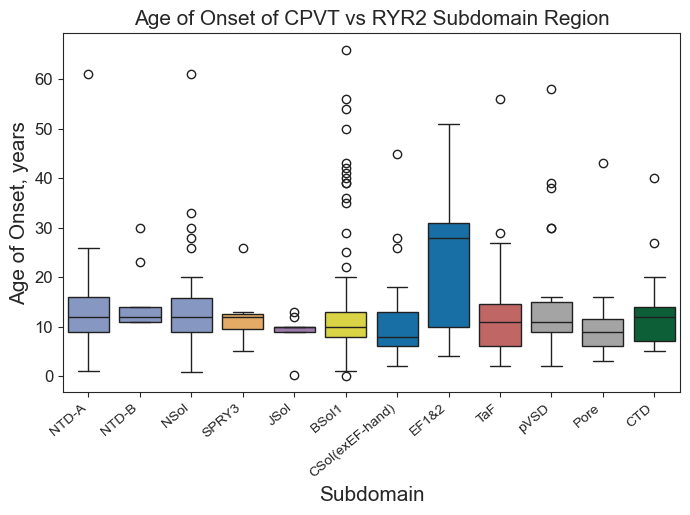

In [181]:
subdomain_color_mapping = {
    row["subdomain"]: "#" + CUSTOM_COLOR_PALLETTE[
        row["domain"].lower().strip()
    ]
    for _, row in sub_domain_gt_5.iterrows()
}

plt.figure(figsize=(FIGURE_3_SIZE[0], FIGURE_3_SIZE[1] * 1.05))

ax = sns.boxplot(
    data=sub_domain_gt_5,
    y=AGE_OF_ONSET_COL,
    x="subdomain",
    linewidth=1,
    width=0.8,
    palette=subdomain_color_mapping,
    hue="subdomain",
    legend=False,
    order=sub_domain_order_gt5,
    # showfliers=False,
)

plt.setp(ax.collections, alpha=.6)

set_figure_size(
    "Subdomain",
    "Age of Onset, years",
    "Age of Onset of CPVT vs RYR2 Subdomain Region",
    x_tick_rotation=40,
    x_tick_ha="right",
    # set sizes 1.5x bigger for ticks and axes
    x_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_label_fontsize=BASE_LABEL_FONT_SIZE * 1.5,
    y_tick_fontsize=BASE_TICK_FONT_SIZE * 1.5,
    x_tick_fontsize=BASE_TICK_FONT_SIZE * 1.25,
    title_fontsize=BASE_TITLE_FONT_SIZE * 1.5
)

save_current_plot("age_of_onset_vs_sub_domain")

plt.show()

In [163]:
# Perform the Kruskal-Wallis test on domains with at least 5 patients
stat_sub_domain, p_sub_domain = stats.kruskal(
    *[group[AGE_OF_ONSET_COL] for _, group in
      sub_domain_gt_5.groupby("subdomain")]
)

print(
    f"Kruskal-Wallis H-test: H={stat_sub_domain:.2f}, P={p_sub_domain:.2g}, n={len(sub_domain_gt_5)}")

Kruskal-Wallis H-test: H=28.73, P=0.0025, n=391


In [148]:
# age of onset vs EXON
pvals_sub_domains = sp.posthoc_dunn(
    sub_domain_gt_5,
    val_col=AGE_OF_ONSET_COL,
    group_col="subdomain",
    p_adjust="bonferroni",
)
pvals_sub_domains

,BSol1,CSol(exEF-hand),CTD,EF1&2,JSol,NSol,NTD-A,NTD-B,Pore,SPRY3,TaF,pVSD
BSol1,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
CSol(exEF-hand),1.0,1.000000,1.0,1.0,1.0,0.034580,0.123309,0.336524,1.000000,1.0,1.0,0.179299
CTD,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
EF1&2,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
JSol,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000
NSol,1.0,0.034580,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.294717,1.0,1.0,1.000000
NTD-A,1.0,0.123309,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.640627,1.0,1.0,1.000000
NTD-B,1.0,0.336524,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.501288,1.0,1.0,1.000000
Pore,1.0,1.000000,1.0,1.0,1.0,0.294717,0.640627,0.501288,1.000000,1.0,1.0,0.652394
SPRY3,1.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000


In [149]:
for c1, c2 in combinations(pvals_sub_domains.columns, 2):
    if pvals_sub_domains.loc[c1, c2] < 0.05:
        print(f"{c1} vs {c2}: {pvals_sub_domains.loc[c1, c2]:.6f}")

CSol(exEF-hand) vs NSol: 0.034580
